In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import numpy as np
import shap
import plotly.express as px


In [2]:
PROCESSED_PATH = "../data/processed/"

df = pd.read_csv(os.path.join(PROCESSED_PATH, 'model_ready_dataset_5min.csv'))
print(df.columns)

df.head()

Index(['INTERVALSTARTTIME_GMT', 'RTM_CONG_PRC', 'RTM_ENE_PRC', 'RTM_LOSS_PRC',
       'RTM_PRC', 'DAM_CONG_PRC', 'DAM_ENE_PRC', 'DAM_GHG_PRC', 'DAM_LOSS_PRC',
       'DAM_PRC', '2DA_LOAD', 'RTPD_DMND', 'RTPD_PRC', 'RTM_PRC_lag75min',
       'RTM_PRC_lag80min', 'RTM_PRC_lag85min', 'RTM_PRC_lag90min',
       'RTM_PRC_lag24hr', '2DA_LOAD_lag1', 'RTPD_DMND_lag1', 'hour',
       'dayofweek', 'month', 'is_weekend', 'is_night'],
      dtype='object')


INTERVALSTARTTIME_GMT  RTM_CONG_PRC  RTM_ENE_PRC  RTM_LOSS_PRC  \
0  2023-01-02 14:00:00+00:00           0.0    213.26000           0.0   
1  2023-01-02 14:05:00+00:00           0.0    197.67000           0.0   
2  2023-01-02 14:10:00+00:00           0.0    195.06000           0.0   
3  2023-01-02 14:15:00+00:00           0.0    207.27322           0.0   
4  2023-01-02 14:20:00+00:00           0.0    244.96500           0.0   

     RTM_PRC  DAM_CONG_PRC  DAM_ENE_PRC  DAM_GHG_PRC  DAM_LOSS_PRC    DAM_PRC  \
0  213.26000           0.0     151.1542          0.0      -2.32777  148.82643   
1  197.67000           0.0     151.1542          0.0      -2.32777  148.82643   
2  195.06000           0.0     151.1542          0.0      -2.32777  148.82643   
3  207.27322           0.0     151.1542          0.0      -2.32777  148.82643   
4  244.96500           0.0     151.1542          0.0      -2.32777  148.82643   

   ...  RTM_PRC_lag85min  RTM_PRC_lag90min  RTM_PRC_lag24hr  2DA_LOAD_lag1  \
0  ...          233.6136          216.0024        115.95011        8565.53   
1  ...          213.2912          233.6136        115.95011        8837.71   
2  ...          218.6124          213.2912        115.95011        8715.03   
3  ...          218.1324          218.6124        115.95011        8756.71   
4  ...          223.1912          218.1324        114.72000        8789.51   

   RTPD_DMND_lag1  hour  dayofweek  month  is_weekend  is_night  
0         8490.66    14          0      1       False     False  
1         8690.41    14          0      1       False     False  
2         8690.41    14          0      1       False     False  
3         8690.41    14          0      1       False     False  
4         8789.51    14          0      1       False     False  

[5 rows x 25 columns]

In [3]:
# Drop rows with missing values
df = df.dropna()


In [4]:
# Create derived features
df['RTPD_Forecast_dmnd_diff'] = df['RTPD_DMND'] - df['2DA_LOAD'] #difference between load forecast and RTPD
df['RTM-DAM'] = df['RTM_PRC'] - df['DAM_PRC'] #difference between DAM and RTM, used as fitting target


In [ ]:
# Define features and target
target = "RTM-DAM"
features = [
    "DAM_PRC",
    "RTPD_PRC",
    "2DA_LOAD",
    "2DA_LOAD_lag1",
    "RTPD_DMND",
    "RTPD_DMND_lag1",
    'RTPD_Forecast_dmnd_diff',
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "is_night",
    "RTM_PRC_lag75min",
    "RTM_PRC_lag80min",
    "RTM_PRC_lag85min",
    "RTM_PRC_lag90min",
    "RTM_PRC_lag24hr",
]

# Split into train/test
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]

test_df = df.iloc[train_size:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [105]:
#define quantile training function

def train_quantile_model(seed, alpha, X_train, y_train):
    model = lgb.LGBMRegressor(
        objective='quantile',      # or 'quantile' if you want quantiles
        alpha=alpha,
        random_state=seed,
        n_estimators=200,
        learning_rate=0.1,
        #subsample=0.8,
        #colsample_bytree=0.8,
        verbose=-1, 
    )
    model.fit(X_train, y_train)
    return model

In [106]:
# Define 95 quantile model ensemble 
seeds = np.arange(0, 50)
y_pred_95 = []
alpha = 0.95

for seed in seeds:
    model = train_quantile_model(seed, alpha, X_train, y_train)
    y_pred_95.append(model.predict(X_test))

In [107]:
# Define 5 quantile model ensemble 
seeds = np.arange(0, 50)
y_pred_05 = []
alpha = 0.05

for seed in seeds:
    model = train_quantile_model(seed, alpha, X_train, y_train)
    y_pred_05.append(model.predict(X_test))

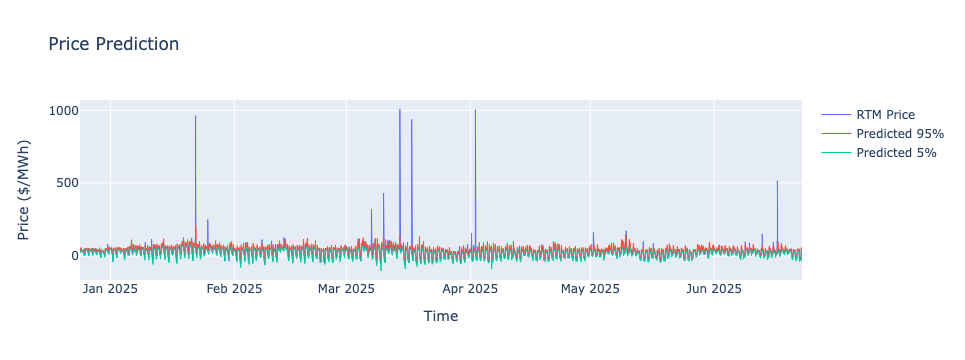

In [108]:
import plotly.graph_objects as go

y_mean_95 = np.mean(y_pred_95, axis=0)
y_mean_05 = np.mean(y_pred_05, axis=0)

dam_pred = X_test['DAM_PRC'][y_test.index]
time = pd.to_datetime(df['INTERVALSTARTTIME_GMT']).dt.tz_convert('America/Los_Angeles')

fig = go.Figure()

fig.add_trace(go.Scatter(x=time[y_test.index], y=y_test.values + dam_pred, mode='lines', name='RTM Price', line=dict(width=1)))

fig.add_trace(go.Scatter(x=time[y_test.index], y=y_mean_95 + dam_pred, mode='lines', name='Predicted 95%', line=dict(width=1)))
fig.add_trace(go.Scatter(x=time[y_test.index], y=y_mean_05 + dam_pred, mode='lines', name='Predicted 5%', line=dict(width=1)))

fig.update_layout(title='Price Prediction',
                  xaxis_title='Time',
                  yaxis_title='Price ($/MWh)')
fig.show()


## Model Quantification

In [109]:
# Measure dataset coverage

upper_coverage = (y_test <= y_mean_95).mean()
print(f'Upper Coverage: {upper_coverage:.{3}}')

lower_coverage = (y_test >= y_mean_05).mean()
print(f'Lower Coverage: {lower_coverage:.{3}}')

coverage = ((y_test >= y_mean_05) & (y_test <= y_mean_95)).mean()
print(f'Total Coverage: {coverage:.{3}}')



Upper Coverage: 0.898
Lower Coverage: 0.979
Total Coverage: 0.877


In [110]:
# Measure prediction spread

avg_width = (y_mean_95 - y_mean_05).mean()
print(f'Average Prediction Width: {avg_width:.{3}} $/MWh')


Average Prediction Width: 17.3 $/MWh


### Feature Importance 

In [111]:
# Feature importance plotting

explainer = shap.Explainer(model)
shap_values = explainer(X_train)


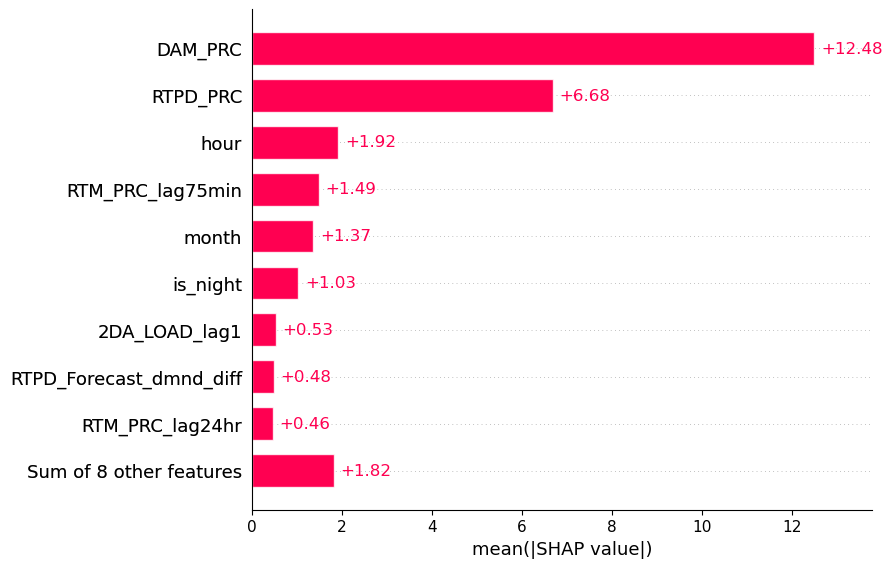

In [112]:
shap.plots.bar(shap_values)